# Senders in TPWG mailing list

We want to analyze participants and patterns of participation on the publicly archived mailing list for the W3C's Tracking Protection Working Group (2011-2019).

<div class="alert alert-info"><b>TODO</b>
Paragraphs that note future work or additional data analysis to try are marked like this paragraph.
</div>

## Setup and load data

Start by importing the necessary libraries.

In [1]:
%matplotlib inline
import bigbang.mailman as mailman
import bigbang.process as process
import bigbang.parse
from bigbang.parse import get_date
from bigbang.archive import Archive
import bigbang.utils as utils
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import pytz
import pickle
import os
import csv
import re
import scipy
import email
import gc
import powerlaw
import mpmath

/home/npdoty/mailing-list-analysis/bigbang/config/config.py:8: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dictionary = yaml.load(stream)


In [2]:
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set()
sns.set_style("white")

In [139]:
def convert_ordinals_to_dates(s): # convenience function for rendering dates in describe tables
    n = []
    if s.name in ['Earliest Date', 'Latest Date']:
        for i, value in s.iteritems():
            if i not in ['std','count']:
                n.append(datetime.date.fromordinal(int(value)).isoformat())
            else:
                n.append(value)
        return pd.Series(data=n, index=s.index, dtype=str)
    return s
def describe_with_dates(df):
    return df.describe().apply(convert_ordinals_to_dates,axis=0)

In [3]:
ml_shortname = "public-tracking"

archive = Archive(ml_shortname, archive_dir='../../w3c-archives', mbox=True)
activity = archive.get_activity(resolved=False)

/home/npdoty/mailing-list-analysis/bigbang/bigbang/mailman.py:156: UserWarning: No mailing list name found at public-tracking
  warnings.warn("No mailing list name found at %s" % url)


Initial look at the total messages sent by each From header and which people have sent the most messages. (This will be corrected/updated based on later steps.)

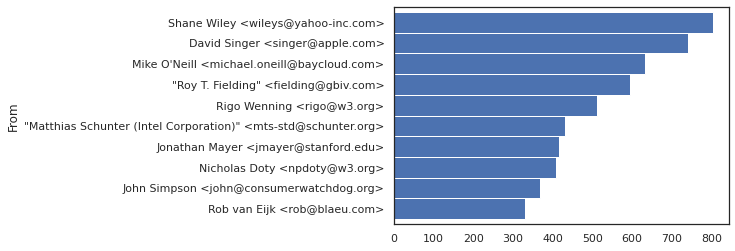

In [4]:
ta = activity.sum(0) # sum along the first axis
ta.sort_values()[-10:].plot(kind='barh', width=1)

## Combining likely duplicates

Some of these senders are probably duplicates, where a single person has used more than one email address, or even the same email address but a different `From` header, to send messages over time. We want to take a pass at combining those duplicate rows. 

We might use other entity resolution methods as well, including identifying clusters of somewhat similar names and manual verification.

In [120]:
resolution_series = ta.copy(deep=True)

In [121]:
resolution_df = pd.DataFrame(data=resolution_series, columns=['Total Messages'])
resolution_df.reset_index(inplace=True)
resolution_df

,From,Total Messages
0,""" mike O'Neill"" <michael.oneill@baycloud.com>",2.0
1,"""(unknown charset) Justin Brookman"" <justin@cd...",1.0
2,"""(unknown charset) Matthias Schunter"" <mts@zur...",51.0
3,"""Aleecia M. McDonald"" <aleecia@aleecia.com>",293.0
4,"""Amy Colando (LCA)"" <acolando@microsoft.com>",69.0
...,...,...
213,rob@blaeu.com,5.0
214,stosss <stosss@gmail.com>,1.0
215,v.toubiana@free.fr,1.0
216,webmaster@w3.org,2.0


In [122]:
name_and_email_columns = resolution_df['From'].apply(
    lambda x: pd.Series(
        [bigbang.parse.normalize_email_address(email.utils.parseaddr(x)[1]),
         bigbang.parse.tokenize_name(bigbang.parse.clean_name(email.utils.parseaddr(x)[0])) if bigbang.parse.clean_name(email.utils.parseaddr(x)[0]) else ''],
        index=['email','name']))

In [123]:
resolution_df = resolution_df.join(name_and_email_columns, how='inner')

In [124]:
resolution_df

,From,Total Messages,email,name
0,""" mike O'Neill"" <michael.oneill@baycloud.com>",2.0,michael.oneill@baycloud.com,mike oneill
1,"""(unknown charset) Justin Brookman"" <justin@cd...",1.0,justin@cdt.org,brookman justin
2,"""(unknown charset) Matthias Schunter"" <mts@zur...",51.0,mts@zurich.ibm.com,matthias schunter
3,"""Aleecia M. McDonald"" <aleecia@aleecia.com>",293.0,aleecia@aleecia.com,aleecia m mcdonald
4,"""Amy Colando (LCA)"" <acolando@microsoft.com>",69.0,acolando@microsoft.com,amy colando lca
...,...,...,...,...
213,rob@blaeu.com,5.0,rob@blaeu.com,
214,stosss <stosss@gmail.com>,1.0,stosss@gmail.com,stosss
215,v.toubiana@free.fr,1.0,v.toubiana@free.fr,
216,webmaster@w3.org,2.0,webmaster@w3.org,


First, let's see the number of exact duplicates, when we just compare normalized email address and normalized name for matching purposes.

In [125]:
resolution_df['email'].describe()

count                      218
unique                     189
top       mts-std@schunter.org
freq                         5
Name: email, dtype: object

In [126]:
resolution_df['name'].describe()

count     218
unique    172
top          
freq       14
Name: name, dtype: object

What are the non-unique normalized names?

In [127]:
names = resolution_df['name'].copy(deep=True)
name_counts = names.value_counts()
name_counts[name_counts > 1][:30]

                               14
brookman justin                 4
matthias schunter               4
brooks dobbs                    3
david wainberg                  3
mike oneill                     3
chris pedigo                    2
craig spiezle                   2
doty nick                       2
hall joseph lorenzo             2
heffernan ronan                 2
joe kathy                       2
chris mejia                     2
cranstone peter                 2
david singer                    2
shane wiley                     2
brendan riordan-butterworth     2
holst van walter                2
bert bos                        2
xueyuan                         2
sid stamm                       2
chester jeffrey                 2
marnau ninja                    2
bratsberg haakon                2
m shane wiley                   2
toubiana vincent                2
john simpson                    2
Name: name, dtype: int64

This subset of the duplicate names gives us a good sense that besides the blank names, the name fields identify to individual people.

Let's group and aggregate to combine the most clear duplicates. For email address, we can just group on that column, and then aggregate, where the function for aggregating each column is appropriate to the meaning of that column (summing total messages, take the minimum of the earliest date and the maximum of the latest date, take the longest name).

In [128]:
email_grouped = resolution_df.groupby('email', as_index=False)

In [129]:
email_aggregated = email_grouped.aggregate({
    'Total Messages': np.sum,
    'name': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
    'From': ','.join
})

In [130]:
email_aggregated.describe()

,Total Messages
count,189.000000
mean,59.798942
std,138.691076
min,1.000000
25%,2.000000
50%,6.000000
75%,49.000000
max,983.000000


In [131]:
email_aggregated[email_aggregated['name']=='']

,email,Total Messages,name,From
56,erik_nilsson@chinadaily.com.cn,1.0,,erik_nilsson@chinadaily.com.cn
61,frank.dawson@nokia.com,3.0,,Frank.Dawson@nokia.com
62,frank.wagner@telekom.de,10.0,,Frank.Wagner@telekom.de
150,rosa.barcelo@ec.europa.eu,2.0,,Rosa.BARCELO@ec.europa.eu
182,webmaster@w3.org,2.0,,webmaster@w3.org


In [132]:
# make separate dataframes for names that are worth matching and names that aren't
email_aggregated_no_name_for_matching = email_aggregated[email_aggregated['name']==''].copy(deep=True)
email_aggregated_for_name_matching = email_aggregated[email_aggregated['name']!=''].copy(deep=True)

In [133]:
len(email_aggregated_no_name_for_matching) + len(email_aggregated_for_name_matching)

189

In [134]:
name_grouped = email_aggregated_for_name_matching.groupby('name', as_index=False)

In [135]:
len(name_grouped)

163

In [136]:
name_aggregated = name_grouped.aggregate({
    'Total Messages': np.sum,
    'From': ','.join,
    'email': ','.join
})

In [137]:
resolved_df = name_aggregated.append(email_aggregated_no_name_for_matching, ignore_index=True)

In [138]:
resolved_df.describe()

,Total Messages
count,168.000000
mean,67.273810
std,148.855221
min,1.000000
25%,1.750000
50%,6.500000
75%,53.500000
max,1016.000000


With that entity resolution step done, we now have **168** senders, most of whom have sent at least 6 messages to the list. There are still a handful of duplicates in there, but we're much closer.

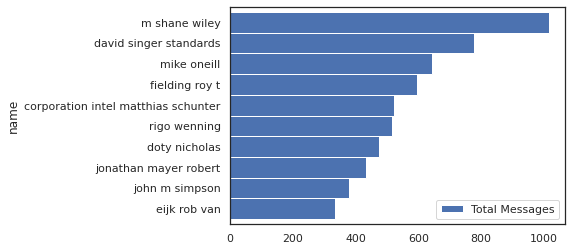

In [140]:
resolved_df.sort_values(by='Total Messages')[-10:].plot(x='name',y='Total Messages',kind='barh', width=1)

The top senders is very, very similar to before, although the order and the total number of messages is different.

## Manual updates

In [141]:
export_df = resolved_df.copy(deep=True)

# we just care about exporting people/addresses for entity resolution
del export_df['Total Messages'] 
export_df.to_csv('people_entity_resolution-%s.csv'% 'public-tracking', encoding='utf-8')

A quick manual review of that spreadsheet can identify a handful more duplicates where the names weren't obviously consistent by the tokenizing algorithm but are clearly the same people. I manually add email addresses to the comma-separated list in the `email` column, and now we'll merge based on that.

Merging and set intersection etc. is unfortunately just very messy with pandas. I apologize.

In [143]:
people_import = pd.read_csv('people_entity_resolution-public-tracking-consolidated.csv', encoding='utf-8', index_col=0, dtype=str)

In [169]:
merged_df = pd.merge(left=resolved_df, right=people_import['email'], on='email', how='outer', indicator=True)

In [174]:
emails_to_combine = merged_df[merged_df['_merge']=='right_only']['email']

In [193]:
def authoritative_index_based_on_to_combine(df, col, ind, to_combine):
    current_email_addresses = df.iloc[ind]['email'].split(',')
    for i, v in to_combine.iteritems():
        other_email_addresses = v.split(',')
                
        intersection = list(set(other_email_addresses) & set(current_email_addresses))
        
        if len(intersection) > 0:
            return v
    return df.iloc[ind]['email']

grouped = resolved_df.groupby(lambda x: authoritative_index_based_on_to_combine(resolved_df, 'email', x, emails_to_combine))

resolved_merged_df = grouped.aggregate({
    'Total Messages': np.sum,
    'name': lambda x: x.iloc[x.str.len().values.argmax()], # the longest string
    'From': ','.join,
    'email': ','.join
}).reset_index(drop=True)

In [196]:
resolved_merged_df.describe()

,Total Messages
count,161.000000
mean,70.198758
std,156.363552
min,1.000000
25%,1.000000
50%,6.000000
75%,59.000000
max,1016.000000


Now there are 161 unique senders.

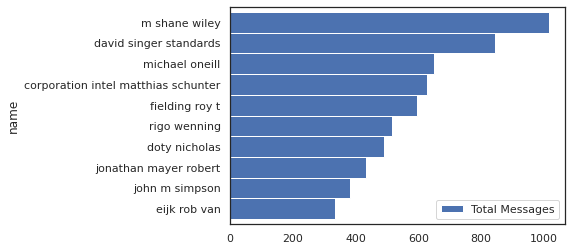

In [195]:
resolved_merged_df.sort_values(by='Total Messages')[-10:].plot(x='name',y='Total Messages',kind='barh', width=1)

## Participation patterns

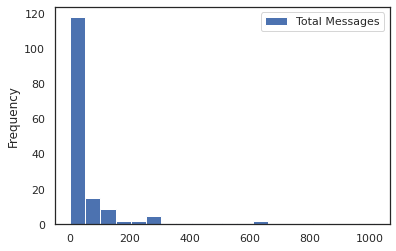

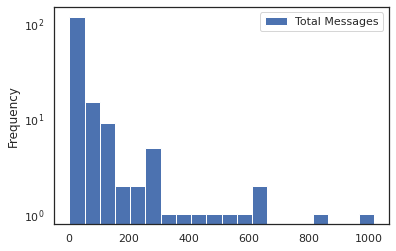

In [204]:
resolved_merged_df[['Total Messages']].plot(kind='hist', bins=20, logy=False, logx=False)
resolved_merged_df[['Total Messages']].plot(kind='hist', bins=20, logy=True, logx=False)

Most people in the group sent just a handful of messages, but then a significant core sent hundreds of messages each, with one person sending over a thousand emails to the list.

Another way to characterize this is through the cumulative percentage of the emails sent.

In [210]:
fractions_df = resolved_merged_df.sort_values(by='Total Messages', ascending=False)

In [215]:
fractions_df['Cumulative Sum'] = fractions_df['Total Messages'].cumsum()
fractions_df['Cumulative Percentage'] = 100*fractions_df['Cumulative Sum']/fractions_df['Total Messages'].sum()
fractions_df.reset_index(inplace=True)

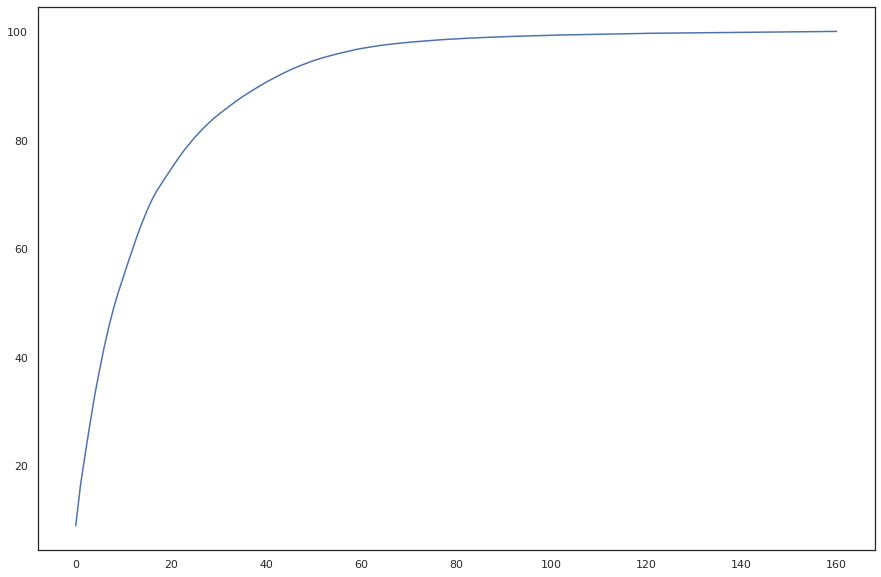

In [216]:
fractions_df['Cumulative Percentage'].plot(figsize=(15,10))

In [207]:
fractions_df['Cumulative Percentage'].describe()

count    161.000000
mean      90.438893
std       17.777904
min        8.989559
25%       90.638825
50%       98.637409
75%       99.646080
max      100.000000
Name: Cumulative Percentage, dtype: float64

One person sent about 9% of the messages. Five people sent a third of the messages. A quarter of the people sent 90% of the messages. This tells you about the group size: I would often think of the group as made up of 30 or 40 regulars, and calls and meetings often had 30-40 people, and they sent the vast majority of the emails.

In [222]:
# fractions_df[:40]

Looking at the most frequent correspondents may be a useful check for my qualitative inquiries as well: these are all familiar names. But it also highlights the lack of diversity. For example, none of the top ten senders, only 1 of the top 25, only 4 of the top 40 senders are women. Frequent correspondents are almost exclusively white, men, and from the United States or Europe.